### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [144]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [145]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [146]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [147]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.98,
#     stability_score_thresh=0.98,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,

)

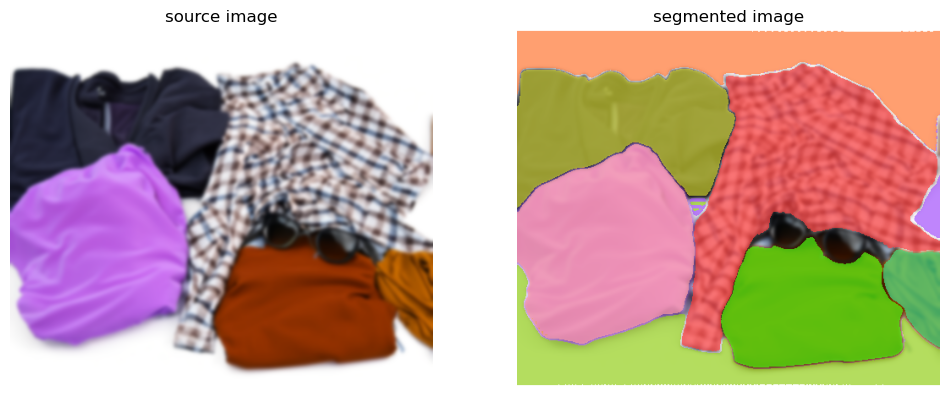

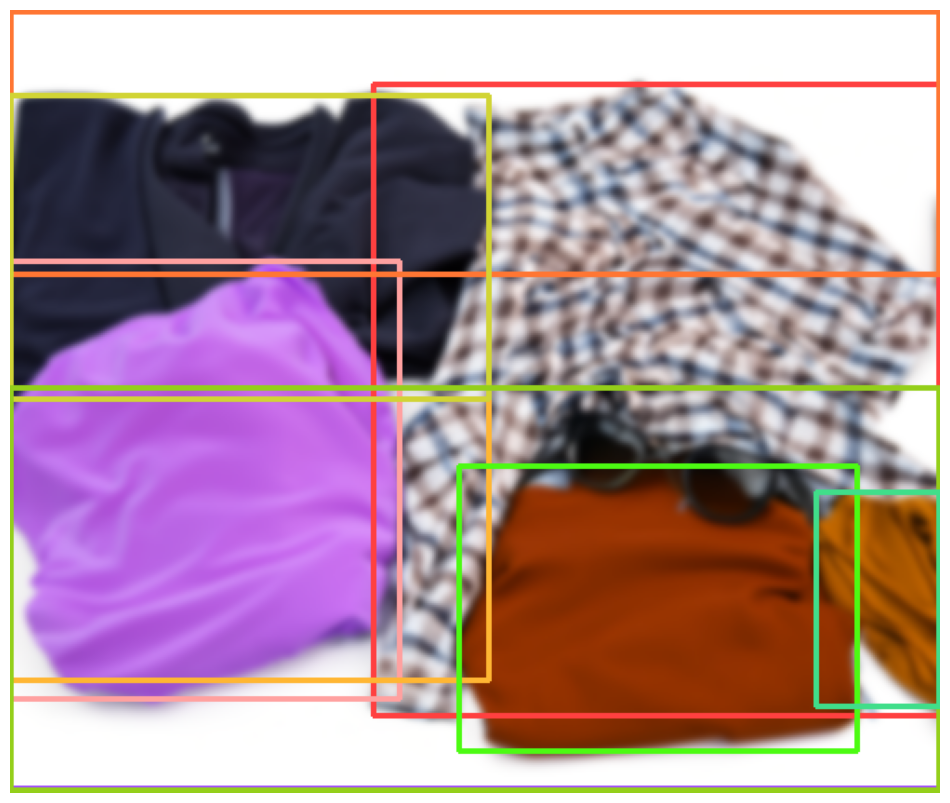

In [160]:
file_name = 'mixed_0003.png'

img_path = get_training_data_path(file_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(image_rgb, (11, 11), 0)

masks = mask_generator.generate(blurred_image)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=0.7)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=blurred_image.copy(), detections=detections)

sv.plot_images_grid(
    images=[blurred_image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_image = bounding_box_annotator.annotate(
    scene=blurred_image, detections=detections)

sv.plot_image(annotated_image)

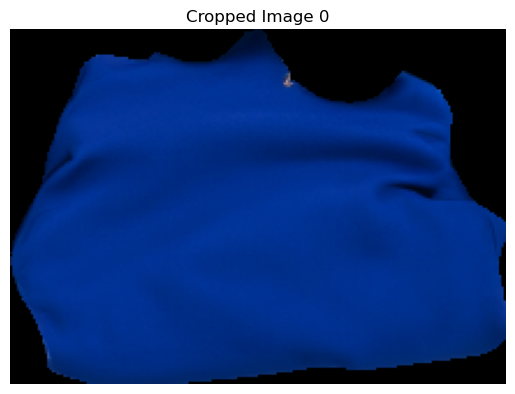

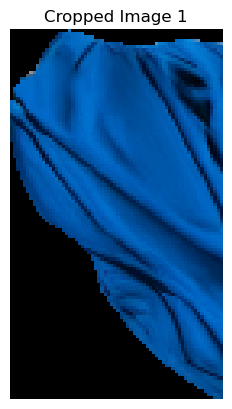

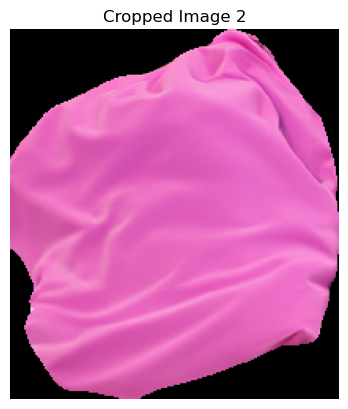

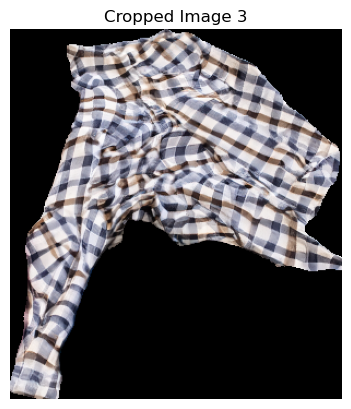

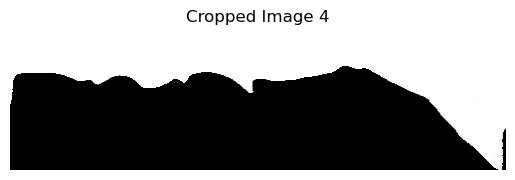

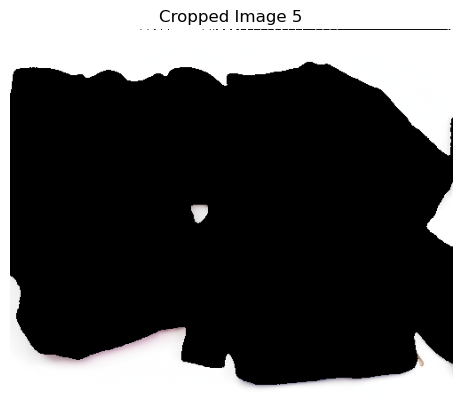

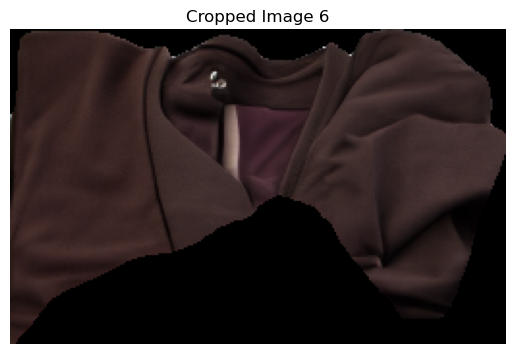

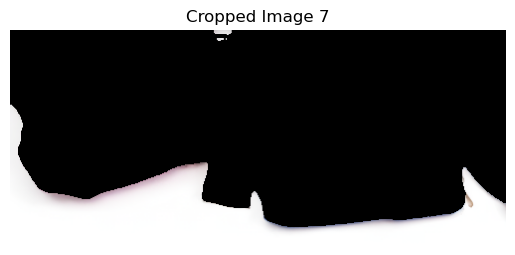

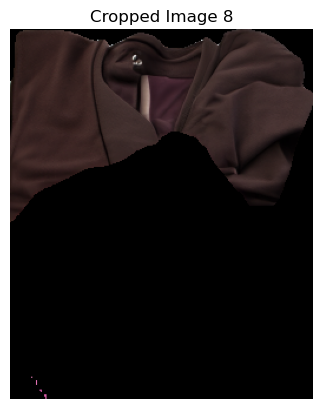

In [161]:
# Assuming 'image' is your original image and 'annotations' is a list of dictionaries containing annotations
from matplotlib import patches


for i, ann in enumerate(masks):
    # Extract bounding box coordinates
    x, y, width, height = map(int, ann['bbox'])  # Ensure integer values
    
    # Define rectangular region
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    mask = np.array(ann['segmentation'], dtype=np.uint8)
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
        
    # Crop the region from the original image
    cropped_image = masked_image[y:y+height, x:x+width]
    # Save the cropped image
    #output_path = f"cropped_image_{i}.jpg"
    #cv2.imwrite(output_path, cropped_image)

    # Optionally, visualize the cropped region
    plt.imshow(cropped_image)
    plt.title(f"Cropped Image {i}")
    plt.axis('off')
    plt.show()